# Evaluate JSON Generation Ability

Use a HuggingFace dataset of BBC News articles to determine the ability of various OpenAI models to generate correct JSON.

In [2]:
from collections import defaultdict
import asyncio
from enum import StrEnum
import json
import math
import re

from datasets import load_dataset
from openai import AsyncOpenAI, OpenAI
from pydantic import BaseModel, Field, ValidationError
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd


In [3]:
nest_asyncio.apply()

## Load Dataset

Load the dataset of BBC News articles. Combine the test and train datasets since we won't be training a model.

In [4]:

dataset = load_dataset("SetFit/bbc-news")

train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
combined_df = pd.concat([train_df, test_df])

print("Dataset Overview:")
print(f"Dataset size: {len(combined_df)}")
print("\nLabel distribution in training set:")
print(combined_df['label_text'].value_counts())
print("\nSample text from training set:")
print(combined_df['text'].iloc[0][:200])

train_df['text_length'] = train_df['text'].str.len()
print(f"\nText length mean: {train_df['text_length'].mean():.2f}")

Dataset Overview:
Dataset size: 2225

Label distribution in training set:
label_text
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Sample text from training set:
wales want rugby league training wales could follow england s lead by training with a rugby league club.  england have already had a three-day session with leeds rhinos  and wales are thought to be in

Text length mean: 2288.95


## Declare Output Schema

Declare the output schema that we want the LLM to generate

In [5]:
class ArticleCategory(StrEnum):
    BUSINESS = "business"
    ENTERTAINMENT = "entertainment"
    POLITICS = "politics"
    SPORT = "sport"
    TECH = "tech"

class NamedEntityType(StrEnum):
    COMPANY = "company"
    COUNTRY = "country"
    LOCATION = "location"
    PERSON = "person"
    TEAM = "team"

class NamedEntity(BaseModel):
    name: str = Field(description="Name of the person, company, etc.")
    type: NamedEntityType = Field(description="Type of named entity")

class NewsArticle(BaseModel):
    title: str = Field(description="Appropriate headline for the news article")
    category: ArticleCategory = Field(description="Category of news that the article belongs to")
    mentioned_entities: list[NamedEntity] = Field(description="List of all named entities in the article", default_factory=list)
    summary: str = Field(description="Brief summary of the article content.")
    length: int = Field(description="Length of the article in words.")



In [6]:
news_article_schema = NewsArticle.model_json_schema()
print(json.dumps(news_article_schema, indent=2))

{
  "$defs": {
    "ArticleCategory": {
      "enum": [
        "business",
        "entertainment",
        "politics",
        "sport",
        "tech"
      ],
      "title": "ArticleCategory",
      "type": "string"
    },
    "NamedEntity": {
      "properties": {
        "name": {
          "description": "Name of the person, company, etc.",
          "title": "Name",
          "type": "string"
        },
        "type": {
          "$ref": "#/$defs/NamedEntityType",
          "description": "Type of named entity"
        }
      },
      "required": [
        "name",
        "type"
      ],
      "title": "NamedEntity",
      "type": "object"
    },
    "NamedEntityType": {
      "enum": [
        "company",
        "country",
        "location",
        "person",
        "team"
      ],
      "title": "NamedEntityType",
      "type": "string"
    }
  },
  "properties": {
    "title": {
      "description": "Appropriate headline for the news article",
      "title": "Title",
    

## Create LLM Prompt

This prompt injects the JSON schema that was generated as well as a news article to analyze.

In [7]:
EXTRACTION_PROMPT = """
Read the news article below and extract the information into a
JSON object. This is the schema you should use to extract the
data. It's provided in standard JSON Schema format.

```json
{news_article_schema}
```

Here is the news article to generate the JSON data for. The article
is surrounded by triple backticks.

```
{news_article}
```

Format your response as a JSON object surrounded by triple backticks
with the 'json' identifier like this:
```json
your JSON object here
```

Be sure to follow the provided schema exactly.
"""

## Run Evaluation

Run an evaluation for all models in `model_names`. The criteria for passing is if the output text can be parsed into a `NewsArticle` object. If the validation fails for any reason then the test fails. The contents of the `NewsArticle` object aren't evaluated.

If this notebook is being run in Github Codespaces, you'll need to set `OPENAI_API_KEY` as a codespace secret in user settings. If it's being run locally then you'll need to set the environment variable `OPENAI_API_KEY`.

In [7]:
async def extract_article_data(article: str, model_name: str, client: AsyncOpenAI, semaphore: asyncio.Semaphore) -> bool:
    """Returns true if JSON is appropriately formatted"""

    formatted_prompt = EXTRACTION_PROMPT.format(
        news_article_schema=json.dumps(news_article_schema, indent=2),
        news_article=article
    )

    async with semaphore:
        response = await client.responses.create(
            model=model_name,
            input=formatted_prompt,
            temperature=0.0,
        )
    extracted_json = response.output_text
    json_match = re.search(r'```json\s*(.*?)\s*```', extracted_json, re.DOTALL)

    if json_match:
        json_content = json_match.group(1).strip()

        try:
            parsed_json = json.loads(json_content)
            _ = NewsArticle.model_validate(parsed_json)
            return True
        except (json.JSONDecodeError, ValidationError) as e:
            return False
    else:
        return False

In [9]:
openai_client = AsyncOpenAI()

ARTICLE_COUNT = 100
MAX_CONCURRENT_TASKS = 3
loop_semaphore = asyncio.Semaphore(MAX_CONCURRENT_TASKS)

success_count = 0
model_names=["gpt-3.5-turbo", "gpt-4-turbo", "gpt-4o-mini"]

results = defaultdict(list)
for model_name in model_names:
    tasks = [extract_article_data(article, model_name, openai_client, loop_semaphore) for article in combined_df['text'][:ARTICLE_COUNT]]

    for f in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
        results[model_name].append(await f)
        
    success_count = sum(1 for result in results[model_name] if result)
    print(f"For {model_name} successfully validated {success_count} of {ARTICLE_COUNT} records")

  0%|          | 0/100 [00:00<?, ?it/s]

For gpt-3.5-turbo successfully validated 84 of 100 records


  0%|          | 0/100 [00:00<?, ?it/s]

For gpt-4-turbo successfully validated 90 of 100 records


  0%|          | 0/100 [00:00<?, ?it/s]

For gpt-4o-mini successfully validated 69 of 100 records


# Display Results

In [10]:
model_success_rates = {}
for model_name, results_list in results.items():
    success_count = sum(1 for result in results_list if result)
    success_rate = (success_count / len(results_list)) * 100
    model_success_rates[model_name] = success_rate


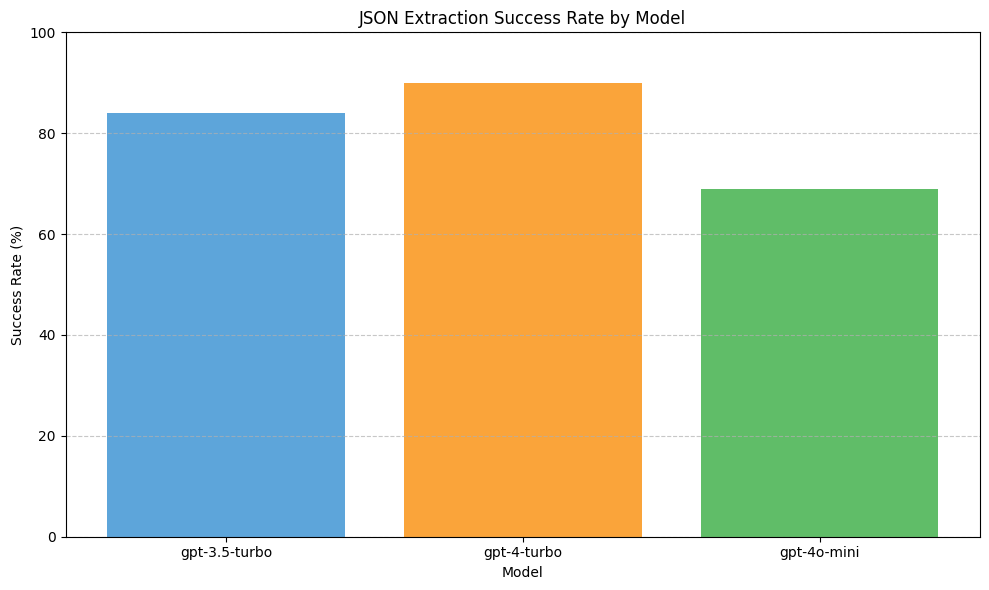

In [11]:

models = list(results.keys())
success_rates = [model_success_rates[model] for model in models]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, success_rates, color=['#5DA5DA', '#FAA43A', '#60BD68'])

plt.xlabel('Model')
plt.ylabel('Success Rate (%)')
plt.title('JSON Extraction Success Rate by Model')
plt.ylim(0, 100)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Analyze Logprobs


In [8]:
def visualize_json_with_heatmap(response):
    """
    Display the JSON output from a model response with a heatmap overlay based on token logprobs.
    
    Args:
        response: The response object from OpenAI API containing logprobs
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    from matplotlib.patches import Rectangle
    import numpy as np
    from IPython.display import display, HTML
    import json
    import re
    
    # Extract the full response text
    full_text = response.choices[0].message.content
    
    # Extract JSON from the response
    json_match = re.search(r'```json\s*(.*?)\s*```', full_text, re.DOTALL)
    if not json_match:
        print("No JSON found in the response")
        return
    
    json_text = json_match.group(1).strip()
    
    # Try to parse and format the JSON for better display
    try:
        parsed_json = json.loads(json_text)
        formatted_json = json.dumps(parsed_json, indent=2)
    except json.JSONDecodeError:
        formatted_json = json_text  # Use the extracted text if parsing fails
    
    # Get tokens and their logprobs
    tokens = []
    probs = []
    
    for token_info in response.choices[0].logprobs.content:
        tokens.append(token_info.token)
        # Convert logprob to probability
        # FIX: Use top_logprobs[0].logprob
        probs.append(np.exp(token_info.top_logprobs[0].logprob))
    
    # Reconstruct the full text from tokens for accurate mapping
    reconstructed_text = ''.join(tokens)
    
    # Find the position of JSON in the full response
    json_pattern = re.escape(json_text)
    json_matches = re.finditer(json_pattern, reconstructed_text, re.DOTALL)
    
    try:
        match = next(json_matches)
        json_start = match.start()
        json_end = match.end()
    except StopIteration:
        # If the escaped pattern doesn't match, try a more lenient approach
        # This might be necessary if there are slight differences in whitespace
        print("Using alternative JSON matching method...")
        cleaned_json = re.sub(r'\s+', '', json_text)
        cleaned_reconstructed = re.sub(r'\s+', '', reconstructed_text)
        json_start = cleaned_reconstructed.find(cleaned_json)
        if json_start == -1:
            print("Could not locate JSON in response tokens, showing full response instead")
            json_start = 0
            json_end = len(reconstructed_text)
        else:
            json_end = json_start + len(cleaned_json)
            # Now map back to original indices with whitespace
            original_pos = 0
            cleaned_pos = 0
            mapped_start = 0
            
            for i, char in enumerate(reconstructed_text):
                if not char.isspace():
                    if cleaned_pos == json_start:
                        mapped_start = i
                        break
                    cleaned_pos += 1
                original_pos += 1
            
            json_start = mapped_start
            # For end, just use the formatted_json length from the starting position
            json_end = json_start + len(json_text)
    
    # Find which tokens correspond to the JSON content
    token_indices = []
    current_pos = 0
    
    for i, token in enumerate(tokens):
        next_pos = current_pos + len(token)
        # Check if this token is part of the JSON content
        if (current_pos >= json_start and current_pos < json_end) or (next_pos > json_start and current_pos < json_end):
            token_indices.append(i)
        current_pos = next_pos
        if current_pos > json_end:
            break
    
    # Create a color map
    # Use 'RdYlGn' reversed so green is high, red is low
    cmap = plt.colormaps['RdYlGn']
    norm = mcolors.Normalize(vmin=0, vmax=1)
    
    # Build HTML with styled spans for each token
    html_parts = []
    html_parts.append('<pre style="font-family: monospace; white-space: pre-wrap; line-height: 1.5;">')
    
    # If for some reason we couldn't find the tokens, display the formatted JSON with neutral styling
    if not token_indices:
        html_parts.append(f'<span>{formatted_json}</span>')
    else:
        # Get the JSON tokens and their probabilities
        json_tokens = [tokens[i] for i in token_indices]
        json_probs = [probs[i] for i in token_indices]
        
        # Display each token with appropriate color
        for token, prob in zip(json_tokens, json_probs):
            # Get the color for this probability
            rgba = cmap(norm(prob))
            rgb = f"rgb({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)})"
            
            # Calculate text color (black for light backgrounds, white for dark)
            luminance = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
            text_color = "black" if luminance > 0.5 else "white"
            
            # Replace special characters for HTML display
            html_token = token.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;').replace('\n', '<br>')
            
            # Add the styled span
            html_parts.append(f'<span style="background-color: {rgb}; color: {text_color};">{html_token}</span>')
    
    html_parts.append('</pre>')
    
    # Add a color bar legend
    html_parts.append('<div style="margin-top: 20px; font-family: sans-serif;">')
    html_parts.append('<p><b>Token Probability Legend:</b></p>')
    html_parts.append('<div style="display: flex; width: 300px; height: 30px;">')
    
    # Create gradient bar
    for i in range(10):
        prob = i / 10
        rgba = cmap(norm(prob))
        rgb = f"rgb({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)})"
        html_parts.append(f'<div style="flex: 1; height: 100%; background-color: {rgb};"></div>')
    
    html_parts.append('</div>')
    html_parts.append('<div style="display: flex; width: 300px; justify-content: space-between;">')
    html_parts.append('<span>0.0</span><span>0.5</span><span>1.0</span>')
    html_parts.append('</div>')
    html_parts.append('</div>')
    
    # Display the HTML
    display(HTML(''.join(html_parts)))

In [9]:
def generate_and_visualize_json(article_idx=0):
    """Generate JSON for an article and visualize the output with heatmap"""
    from openai import OpenAI
    
    # Set up client
    client = OpenAI()
    article = combined_df['text'].iloc[article_idx]
    
    # Use the prompt with schema
    formatted_prompt = EXTRACTION_PROMPT.format(
        news_article_schema=json.dumps(news_article_schema, indent=2),
        news_article=article
    )
    
    # Call the API with logprobs
    response = client.beta.chat.completions.parse(
        model="gpt-4o-mini",  # Or any other model you want to test
        messages=[{"role": "user", "content": formatted_prompt}],
        temperature=0.0,
        logprobs=True,
        top_logprobs=1
    )
    
    # Visualize the result
    visualize_json_with_heatmap(response)
    
    return response

In [ ]:
response = generate_and_visualize_json(6)


In [13]:
response = generate_and_visualize_json(10)


## Create LLM Prompt

This prompt injects the JSON schema that was generated as well as a news article to analyze.

In [ ]:
STRUCTURED_EXTRACTION_PROMPT = """
Read the news article below and extract the information into a
JSON object. 

Here is the news article to generate the JSON data for. The article
is surrounded by triple backticks.

```
{news_article}
```

"""

## Run Evaluation

Run an evaluation for all models in `model_names`. The criteria for passing is if the output text can be parsed into a `NewsArticle` object.

If this notebook is being run in Github Codespaces, you'll need to set `OPENAI_API_KEY` as a codespace secret in user settings. If it's being run locally then you'll need to set the environment variable `OPENAI_API_KEY`.

In [ ]:
async def extract_article_data(article: str, model_name: str, client: AsyncOpenAI, semaphore: asyncio.Semaphore) -> bool:
    """Returns true if JSON is appropriately formatted"""

    formatted_prompt = STRUCTURED_EXTRACTION_PROMPT.format(news_article=article)

    async with semaphore:
        response = await client.beta.chat.completions.parse(
            model=model_name,
            messages=[{"role": "user", "content": formatted_prompt}],
            temperature=0.0,
            response_format = NewsArticle
        )

        news_article = response.choices[0].message.parsed
        return isinstance(news_article, NewsArticle)

In [ ]:
openai_client = AsyncOpenAI()

ARTICLE_COUNT = 100
MAX_CONCURRENT_TASKS = 4
loop_semaphore = asyncio.Semaphore(MAX_CONCURRENT_TASKS)

success_count = 0
model_names=["gpt-4o-mini"]
# model_names=["gpt-3.5-turbo", "gpt-4-turbo", "gpt-4o-mini"]

results = defaultdict(list)
for model_name in model_names:
    tasks = [extract_article_data(article, model_name, openai_client, loop_semaphore) for article in combined_df['text'][:ARTICLE_COUNT]]

    for f in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
        results[model_name].append(await f)
        
    success_count = sum(1 for result in results[model_name] if result)
    print(f"For {model_name} successfully validated {success_count} of {ARTICLE_COUNT} records")

  0%|          | 0/100 [00:00<?, ?it/s]

For gpt-4o-mini successfully validated 100 of 100 records


## Display Results

In [ ]:
model_success_rates = {}
for model_name, results_list in results.items():
    success_count = sum(1 for result in results_list if result)
    success_rate = (success_count / len(results_list)) * 100
    model_success_rates[model_name] = success_rate


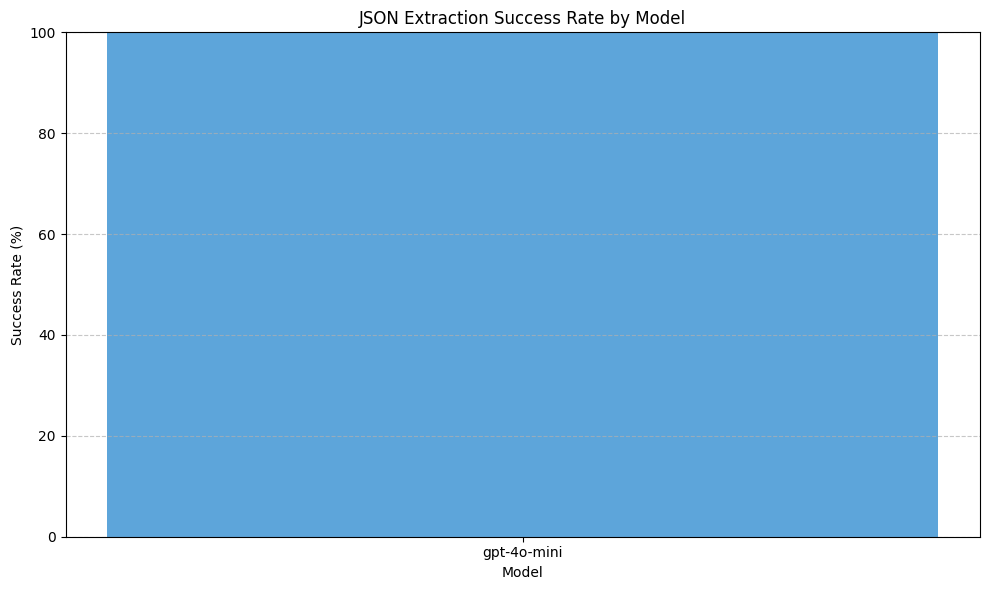

In [ ]:

models = list(results.keys())
success_rates = [model_success_rates[model] for model in models]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, success_rates, color=['#5DA5DA', '#FAA43A', '#60BD68'])

plt.xlabel('Model')
plt.ylabel('Success Rate (%)')
plt.title('JSON Extraction Success Rate by Model')
plt.ylim(0, 100)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()